## Data Related

### Clipping

In [16]:
def apply_clip(df, str_col, pct_lower, pct_upper):
    LB, UB = np.percentile(df[str_col], [pct_lower, pct_upper])
    df[str_col] = np.clip(df[str_col], LB, UB)
    del LB, UB; gc.collect()

### Interpolation

In [17]:
def apply_interpolation(df, subject_cols, int_order, supp_median_fill=False):
    lin = lambda var: var.interpolate(method='linear', limit_direction='both')
    pol = lambda var: var.interpolate(method='polynomial', order=int_order, limit_direction='both')
    
    # ===== in ASHRAE, grouping was done via site_id =====
    # linear = df.groupby(grouping_col).apply(lin)
    # polyno = df.groupby(grouping_col).apply(pol)
    
    linear = df[subject_cols].apply(lin)
    polyno = df[subject_cols].apply(pol)
    df[subject_cols] = (linear[subject_cols] + polyno[subject_cols]) * 0.5
    
    # ===== if missing value remains: =====
    if supp_median_fill:
        #[col for col in cols if temp[col].isna().sum() > 0]
        for col in subject_cols:
            df[col].fillna(df[col].median(), inplace=True)
            del col
    del lin, pol, linear, polyno; gc.collect()

### Dist. Normalizer

In [336]:
from scipy.stats import yeojohnson
from scipy.stats import jarque_bera
#from scipy.special import boxcox1p
#from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [467]:
class apply_standardize:
    def jarque_bera_test(df, str_col, how, alpha):
        if any(alpha):
            assert df[f'{str_col}_{how}'].shape[0] >= 2000, print('Not enough samples (>=2000)')
            test_stat, p_val = jarque_bera(df[f'{str_col}_{how}'])
            print(f'Jarque-Bera (χ2) Normality Check:\n- H0: is normally distributed\n- H1: not from normal dist')
            print(f'test-stat - {test_stat}\np-value - {p_val}\n')
            for a in alpha:
                if p_val < a:
                    print(f'sig_lev: {a}\nRejected 0 - nonnormal')
                elif p_val > a:
                    print(f"sig_lev: {a}\nRej Fail'd - normal")

    def internal_apply(df, str_col, how):
        if how == 'Z':
            sc = StandardScaler()
            temp = df[str_col].values.reshape(df[str_col].shape[0], 1)
            return sc.fit_transform(temp)
        elif how == 'minmax':
            ms = StandardScaler()
            temp = df[str_col].values.reshape(df[str_col].shape[0], 1)
            return ms.fit_transform(temp)
        elif how == 'yeo':
            yeo, yeo_lam = yeojohnson(df[str_col])
            return yeo
        else:
            raise NotImplementedError("Acceptable arg how: 'Z', 'minmax', 'yeo'")

    def apply_ln(df, str_col):
        temp_count = df[f'{str_col}'].isna().sum()
        df[f'{str_col}'] = np.log1p(df[f'{str_col}'])
        if df[f'{str_col}'].isna().sum() > temp_count:
            print(f"New nan in '{str_col}' via apply_nonlinear")
        del temp_count; gc.collect()

    def apply(df, str_col, how, alpha=[], overwrite=True):
        transformed = apply_standardize.internal_apply(df=df, str_col=str_col, how=how)
        if overwrite:
            df[f'{str_col}'] = transformed
            apply_standardize.jarque_bera_test(df=df, str_col=str_col,
                                             how=how, alpha=alpha)
        elif not overwrite:
            df[f'{str_col}_{how}'] = transformed
            apply_standardize.jarque_bera_test(df=df, str_col=str_col,
                                             how=how, alpha=alpha)
            del df[f'{str_col}']; gc.collect()

    def yeo_lambda():
        None
    def denormalize(lam_tup):
        None

,gauss
0,0.748642
1,0.741789
2,0.398563
3,0.903010
4,0.363437


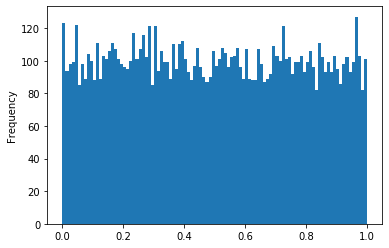

In [468]:
x_box = pd.DataFrame(np.random.rand(10000), columns=['gauss'])
x_box.gauss.plot.hist(bins=100)
x_box.head()

In [469]:
apply_standardize.apply(x_box, 'gauss', how='yeo', alpha=[0.3], overwrite=False)
x_box.head()

Jarque-Bera (χ2) Normality Check:
- H0: is normally distributed
- H1: not from normal dist
test-stat - 599.9084574751167
p-value - 0.0

sig_lev: 0.3
Rejected 0 - nonnormal


,gauss_yeo
0,0.679267
1,0.673542
2,0.376595
3,0.806379
4,0.344946


### Adversarial Validation with LightGBM

In [318]:
def lgb_kfold_adv(X_train, X_test, category_cols, n_splits=5, shuffle=True):
    X_train_adv = X_train.copy()
    X_test_adv = X_test.copy()
    X_train_adv['is_test'] = 0
    X_test_adv['is_test'] = 1
    X_adv = pd.concat([X_train_adv, X_test_adv], axis=0).reset_index(drop=True)
    y_adv = X_adv['is_test'].values
    del X_adv['is_test']; gc.collect()
    
    
    split = build_cv_spliter(X_train=X_adv,
                             y_train=y_adv,
                             strategy='stratified',
                             n_splits=n_splits,
                             shuffle=shuffle,
                             seed=8982)
    
    oofs, models, fimp = lgb_kfold_clf(X_train=X_adv,
                                       y_train=y_adv,
                                       category_cols=category_cols,
                                       split=split,
                                       bayes_opt=False)
    
    return fimp

In [508]:
x_train = pd.DataFrame(np.random.randn(200), columns=['gauss'])
x_test = pd.DataFrame(np.random.randn(200)+3, columns=['gauss'])
common_cols = list(set(x_train.columns).intersection(set(x_test.columns)))

In [509]:
lgb_kfold_adv(x_train, x_test, category_cols=[], n_splits=5, shuffle=True)

========== LightGBM Classifier training on : (400, 1) ==========
========== LightGBM Classifier training: 1/5 fold ==========
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	training's auc: 0.985469	valid_1's auc: 0.989062



C:\Users\ome3\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


========== LightGBM Classifier training: 2/5 fold ==========
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.98625	valid_1's auc: 0.98

========== LightGBM Classifier training: 3/5 fold ==========
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.983789	valid_1's auc: 0.985

========== LightGBM Classifier training: 4/5 fold ==========
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.984141	valid_1's auc: 0.981563

========== LightGBM Classifier training: 5/5 fold ==========
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.985137	valid_1's auc: 0.970625

CV AVG: auc - 0.98125
CV STD: auc - 0.006158708265537508


,feature,importance,fold
0,gauss,162,1
0,gauss,42,2
0,gauss,31,3
0,gauss,47,4
0,gauss,33,5
